In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [8]:
# Path to dataset
data_dir = 'archive_affectnet'

# Load the dataset
data = pd.read_csv(os.path.join(data_dir, 'labels.csv'))

# Display first few rows
data.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [31]:
# Define the size for resizing images
img_size = 48

# Function to preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Apply preprocessing
data['image'] = data['pth'].apply(lambda x: preprocess_image(os.path.join(data_dir, x)))

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Split data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

Labels before encoding: [7 0 2 3 6 1 5 4]
Labels after encoding: [0 1 2 3 4 5 6 7]


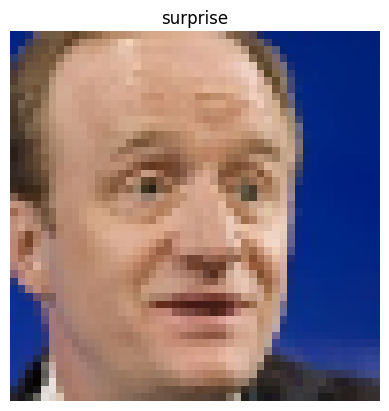

In [32]:
# Check label encoding
print("Labels before encoding:", data['label'].unique())
print("Labels after encoding:", label_encoder.classes_)

EMOTIONS = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Display random image with label
idx = np.random.randint(len(train_data))
img = train_data.iloc[idx]['image']
label = train_data.iloc[idx]['label']

plt.imshow(img)
plt.title(EMOTIONS[label])
plt.axis('off')
plt.show()

In [33]:
# Image data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    np.array(list(train_data['image'])),
    train_data['label'],
    batch_size=32
)

val_generator = val_datagen.flow(
    np.array(list(val_data['image'])),
    val_data['label'],
    batch_size=32
)

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling2D, Reshape, multiply, ReLU, Add, Input)
from tensorflow.keras.models import Sequential, Model

# SEBlock Implementation
def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(channels // reduction, activation='relu')(x)
    x = Dense(channels, activation='sigmoid')(x)
    x = Reshape((1, 1, channels))(x)
    return multiply([input_tensor, x])

# Residual Block Implementation
def residual_block(input_tensor, filters, stride=1):
    shortcut = input_tensor

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Modified Model
def build_model(input_shape=(48, 48, 3), num_classes=8):
    inputs = Input(shape=input_shape)

    # Initial Conv Blocks
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (5, 5), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Add SEBlock
    x = se_block(x)

    # Residual Blocks
    x = residual_block(x, 512, stride=1)
    x = residual_block(x, 512, stride=2)

    # Flatten and Fully Connected Layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build and Compile Model
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 48, 48,    │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 48, 48,    │     18,496 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 24, 24,    │          0 │ max_pooling2d_15… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 24, 24,    │    204,928 │ dropout_23[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 12, 12,    │          0 │ max_pooling2d_16… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 12, 12,    │    590,336 │ dropout_24[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      2,048 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 6, 6, 512) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 6, 6, 512) │          0 │ max_pooling2d_17… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ dropout_25[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │     16,416 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 512)       │     16,896 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,881,576 (45.32 MB)

 Trainable params: 11,873,512 (45.29 MB)

 Non-trainable params: 8,064 (31.50 KB)

In [25]:
img_size=48

In [42]:
epochs = 45
batch_size = 64

In [43]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = val_generator)

Epoch 1/45
705/705 ━━━━━━━━━━━━━━━━━━━━ 532s 744ms/step - accuracy: 0.1404 - loss: 2.5018 - val_accuracy: 0.1595 - val_loss: 2.0955
Epoch 2/45
705/705 ━━━━━━━━━━━━━━━━━━━━ 544s 771ms/step - accuracy: 0.1521 - loss: 2.1938 - val_accuracy: 0.1785 - val_loss: 2.0742
Epoch 3/45
705/705 ━━━━━━━━━━━━━━━━━━━━ 543s 770ms/step - accuracy: 0.1789 - loss: 2.1306 - val_accuracy: 0.1823 - val_loss: 2.1047
Epoch 4/45
705/705 ━━━━━━━━━━━━━━━━━━━━ 542s 768ms/step - accuracy: 0.1791 - loss: 2.1071 - val_accuracy: 0.2202 - val_loss: 2.0214
Epoch 5/45
705/705 ━━━━━━━━━━━━━━━━━━━━ 541s 767ms/step - accuracy: 0.2134 - loss: 2.0453 - val_accuracy: 0.2211 - val_loss: 2.1062
Epoch 6/45
705/705 ━━━━━━━━━━━━━━━━━━━━ 540s 766ms/step - accuracy: 0.2727 - loss: 1.9411 - val_accuracy: 0.3189 - val_loss: 1.8464
Epoch 7/45
705/705 ━━━━━━━━━━━━━━━━━━━━ 542s 769ms/step - accuracy: 0.2997 - loss: 1.8523 - val_accuracy: 0.3397 - val_loss: 1.9432
Epoch 8/45
705/705 ━━━━━━━━━━━━━━━━━━━━ 541s 767ms/step - accuracy: 0.3486 -

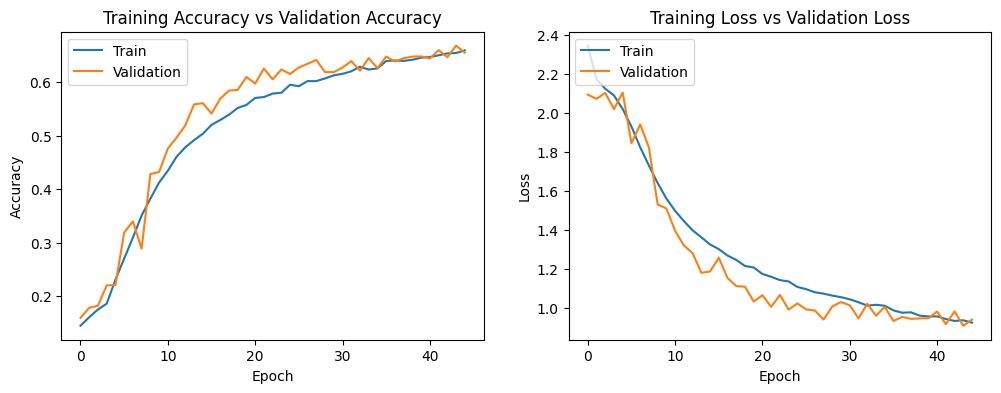

In [44]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [45]:
model.save_weights('model_weights_resemotenet_changed2affectnet.weights.h5')

In [46]:
model.save('model_resemotenet_changed2affectnet.h5')  # No restriction on `.weights.h5` here